In [1]:
# Allow src folder to be imported from this notebook
import sys
from pathlib import Path

module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

# ILP Formulation to cover an MSA with Blocks
___

- [X] Select minimum set of blocks covering the MSA
- [] Create a graph from the selected blocks
- [] Visualize the graph
- [] Output the graph in gfa format

In [2]:
import json
import gurobipy as gp
from gurobipy import GRB
from src.blocks import Block
from src.msa import AnalyzerMSA

# pangenome graph
from src.graph import (
    nodes_edges_from_blocks, 
    PlotGraph
)
from src.graph.bandage_labels_from_gfa import bandage_labels

In [3]:
# MSA
NAME_MSA = "Cluster_6892"
amsa = AnalyzerMSA()
path_msa = f"../msas/{NAME_MSA}.fa"
align, n_seqs, n_cols = amsa.load_msa(path_msa)
n_seqs, n_cols

(3, 158)

**Blocks for each position (r,c) in the MSA** 

$({r},c,c,MSA[r,c])$

In [4]:
blocks_one_char = []
for col in range(n_cols):
    for row in range(n_seqs):
        blocks_one_char.append(
            Block(K=(row,), i=col, j=col, label=align[row,col])
        )

blocks_one_char[:3]

[Block(K=(0,), i=0, j=0, label='C'),
 Block(K=(1,), i=0, j=0, label='-'),
 Block(K=(2,), i=0, j=0, label='-')]

**Set of blocks from the  decomposition**

In [5]:
# Load set of decomposed blocks
path_blocks = f"../experiment/block_decomposition/{NAME_MSA}.json"

with open(path_blocks) as fp:
    decomposed_blocks = [Block(*block) for block in json.load(fp)] 

decomposed_blocks[:3]

[Block(K=(1, 2), i=28, j=34, label='AAAACAA'),
 Block(K=(1, 2), i=28, j=32, label='AAAAC'),
 Block(K=(0, 2), i=77, j=79, label='TCA')]

In [6]:
# set B: input blocks (maximal blocks, the decompositions under intersection by pairs and blocks of one position in the MSA)
set_B = decomposed_blocks + blocks_one_char
# set_B = blocks_one_char

# write idx for blocks 
blocks = [(",".join([str(r) for r in b.K]), b.i, b.j) for b in set_B] # (K,i,j)

# write idx for MSA positions (row, col)
msa_positions = [(r,c) for r in range(n_seqs) for c in range(n_cols)] 

# dictionary to store the string of each block indexed as Gurobipy uses it
strings_ = { (",".join([str(_) for _ in b.K]), b.i, b.j): b.label for b in set_B}

In [7]:
def check_intersection(block1,block2):
    "intersection of blocks "
    block1_K = block1[0].split(",")
    block2_K = block2[0].split(",")

    # check for not empty intersection, otherwise skip to the next block1 in the list
    common_rows = list(set(block1_K).intersection(set(block2_K))) # intersection set K
    common_cols = list(set(range(block1[1],block1[2]+1)).intersection(set(range(block2[1],block2[2]+1)))) # intersection columns [i,j]

    return True if common_rows and common_cols else False

# example
block1 = ("1,2",1,1)
block2 = ("3",1,3)
check_intersection(block1, block2)

False

In [8]:
# Create the model
model = gp.Model("pangeblocks")

# define variables
C = model.addVars(blocks, vtype=GRB.BINARY, name="C")
U = model.addVars(msa_positions, vtype=GRB.BINARY, name="U")

# Constraints: 
for r,c in msa_positions:

    # subset of blocks that covers the position [r,c]
    subset_C = [ C[K,i,j] for K,i,j in blocks if str(r) in K.split(",") and i<=c<=j ]
    if len(subset_C):
        # print(f"{len(subset_C)} blocks cover the position {(r,c)}")
        
        ## 1. each position in the MSA is covered ONLY ONCE
        model.addConstr( U[r,c] <= sum(subset_C), name=f"constraint1({r},{c})")
        
        ## 2. each position of the MSA is covered AT LEAST by one block
        model.addConstr( U[r,c] >= 1, name=f"constraint2({r},{c})")


## 3. overlapping blocks cannot be chosen
# sort all blocks, 
blocks = sorted(blocks, key=lambda b: b[1]) # sort blocks by the starting position (K,start,end)

# and analyze the intersections while update the constraints
names_constraint3=[]
for pos1,block1 in enumerate(blocks[:-1]):
    # compare against the next blocks in the sorted list
    for rel_pos, block2 in enumerate(blocks[pos1+1:]):
        pos2 = rel_pos + pos1 + 1
        block2 = blocks[pos2]
        
        # check for not empty intersection, otherwise, skip to the next block  
        # note: set K is a string with the rows concatenated by a "," (due to Gurobi requirements for index the variables)
        block1_K = block1[0].split(",")
        block2_K = block2[0].split(",")

        # check for not empty intersection, otherwise skip to the next block1 in the list
        common_rows = list(set(block1_K).intersection(set(block2_K))) # intersection set K
        common_cols = list(set(range(block1[1],block1[2]+1)).intersection(set(range(block2[1],block2[2]+1)))) # intersection columns [i,j]

        if (common_rows and common_cols):
            
            # if the blocks intersect, then create the restriction 
            K1,i1,j1=block1
            K2,i2,j2=block2
            name_constraint=f"constraint3({K1},{i1},{j1})-({K2},{i2},{j2})"
            model.addConstr(C[block1] + C[block2] <= 1 , name=name_constraint)
            names_constraint3.append(name_constraint)

# Objective function
model.setObjective(C.sum('*','*','*'), GRB.MINIMIZE)

model.optimize()

Path("ilp-models").mkdir(exist_ok=True)
model.write(f"ilp-models/{NAME_MSA}.lp")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-29
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 32 physical cores, 64 logical processors, using up to 32 threads
Optimize a model with 2650 rows, 988 columns and 6397 nonzeros
Model fingerprint: 0x615a606d
Variable types: 0 continuous, 988 integer (988 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 474.0000000
Presolve removed 2645 rows and 983 columns
Presolve time: 0.04s
Presolved: 5 rows, 5 columns, 17 nonzeros
Found heuristic solution: objective 78.0000000
Variable types: 0 continuous, 5 integer (5 binary)

Explored 0 nodes (0 simplex iterations) in 0.06 seconds (0.03 work units)
Thread count was 32 (of 64 available processors)

Solution count 2: 78 474 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.

In [9]:
"constraint3(1,2,0,3)-(0,1,1,5)" in names_constraint3

False

In [10]:
solution_C = model.getAttr("X", C)
solution_U = model.getAttr("X",U)
len(solution_C)>0, len(solution_U)>0

(True, True)

In [11]:
used_blocks = []
for k,v in solution_C.items(): 
    K,i,j=k
    if v > 0:
        used_blocks.append(
            Block(eval(f"({K},)"),i,j, strings_[K,i,j])
        )

In [12]:
sorted_solution=sorted(used_blocks, key=lambda b: b.i)
len(sorted_solution), sorted_solution

(78,
 [Block(K=(1, 2), i=0, j=25, label='--------------------------'),
  Block(K=(0,), i=0, j=0, label='C'),
  Block(K=(0,), i=1, j=1, label='C'),
  Block(K=(0,), i=2, j=2, label='A'),
  Block(K=(0,), i=3, j=3, label='G'),
  Block(K=(0,), i=4, j=4, label='A'),
  Block(K=(0,), i=5, j=5, label='T'),
  Block(K=(0,), i=6, j=6, label='G'),
  Block(K=(0,), i=7, j=7, label='C'),
  Block(K=(0,), i=8, j=8, label='C'),
  Block(K=(0,), i=9, j=9, label='G'),
  Block(K=(0,), i=10, j=10, label='C'),
  Block(K=(0,), i=11, j=11, label='A'),
  Block(K=(0,), i=12, j=12, label='C'),
  Block(K=(0,), i=13, j=13, label='C'),
  Block(K=(0,), i=14, j=14, label='C'),
  Block(K=(0,), i=15, j=15, label='A'),
  Block(K=(0,), i=16, j=16, label='G'),
  Block(K=(0,), i=17, j=17, label='G'),
  Block(K=(0,), i=18, j=18, label='G'),
  Block(K=(0,), i=19, j=19, label='C'),
  Block(K=(0,), i=20, j=20, label='A'),
  Block(K=(0,), i=21, j=21, label='G'),
  Block(K=(0,), i=22, j=22, label='T'),
  Block(K=(0,), i=23, j=23, l

## Graph construction

In [13]:
from dataclasses import astuple 
list_nodes = []
list_edges = []

for pos1, block1 in enumerate(sorted_solution[:-1]):
    for rel_pos, block2 in enumerate(sorted_solution[pos1+1:]):
        pos2 = rel_pos + pos1 + 1

        nodes, edges = nodes_edges_from_blocks(block1, block2)
        list_nodes.extend(nodes)
        list_edges.extend(edges)

Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Condicion- consecutive blocks
Condicion- consecutive blocks
Condicion- consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecutive blocks
Not consecuti

In [14]:
k,i,j,b=list_edges[0].node1

In [15]:
_list_nodes = set([(node.K,node.i,node.j,node.label) for node in list_nodes])
_list_nodes

{((0,), 0, 0, 'C'),
 ((0,), 1, 1, 'C'),
 ((0,), 2, 2, 'A'),
 ((0,), 3, 3, 'G'),
 ((0,), 4, 4, 'A'),
 ((0,), 5, 5, 'T'),
 ((0,), 6, 6, 'G'),
 ((0,), 7, 7, 'C'),
 ((0,), 8, 8, 'C'),
 ((0,), 9, 9, 'G'),
 ((0,), 10, 10, 'C'),
 ((0,), 11, 11, 'A'),
 ((0,), 12, 12, 'C'),
 ((0,), 13, 13, 'C'),
 ((0,), 14, 14, 'C'),
 ((0,), 15, 15, 'A'),
 ((0,), 16, 16, 'G'),
 ((0,), 17, 17, 'G'),
 ((0,), 18, 18, 'G'),
 ((0,), 19, 19, 'C'),
 ((0,), 20, 20, 'A'),
 ((0,), 21, 21, 'G'),
 ((0,), 22, 22, 'T'),
 ((0,), 23, 23, 'A'),
 ((0,), 24, 24, 'A'),
 ((0,), 25, 25, 'A'),
 ((0,), 26, 26, 'T'),
 ((0,), 28, 28, 'A'),
 ((0,), 29, 29, 'A'),
 ((0,), 30, 30, 'A'),
 ((0,), 31, 31, 'A'),
 ((0,), 32, 32, 'A'),
 ((0,), 33, 33, 'A'),
 ((0,), 34, 34, 'C'),
 ((0,), 35, 35, 'A'),
 ((0,), 36, 36, 'A'),
 ((0,), 37, 37, 'A'),
 ((0,), 46, 46, 'C'),
 ((0,), 47, 47, 'T'),
 ((0,), 66, 66, 'G'),
 ((0,), 77, 77, 'T'),
 ((0,), 80, 80, 'G'),
 ((0,), 83, 83, 'A'),
 ((0,), 95, 95, 'G'),
 ((0,), 154, 154, 'A'),
 ((0,), 155, 155, 'T'),
 ((0

In [16]:
_list_edges = []
for edge in list_edges:
    node1=edge.node1
    node2=edge.node2

    _list_edges.append(
        ((node1.K,node1.i,node1.j,node1.label),(node2.K,node2.i,node2.j,node2.label), tuple(edge.seqs))
    )

_list_edges = list(set(_list_edges))

In [17]:
_list_edges[:3]

[(((0, 1, 2), 38, 45, 'CCCGGCTG'), ((2,), 46, 46, 'G'), (2,)),
 (((0,), 33, 33, 'A'), ((0,), 34, 34, 'C'), (0,)),
 (((0,), 156, 156, 'T'), ((0,), 157, 157, '-'), (0,))]

In [18]:
from src.flow.plot_graph import PlotGraph
# node2str = lambda node: f"K=({','.join(str(_) for _ in node.K)}),i={node.i},j={node.j},{node.label}"
# nodes_plot = [node2str(node) for node in list_nodes]
# edges_plot = [(node2str(edge[0]),node2str(edge[1])) for edge in list_edges]
dg = PlotGraph()
# dg.create_dot_graph(nodes_plot, edges_plot)
# dg.show()
dg(nodes=list_nodes, edges=list_edges, path_save=f"plots/{NAME_MSA}.dot")


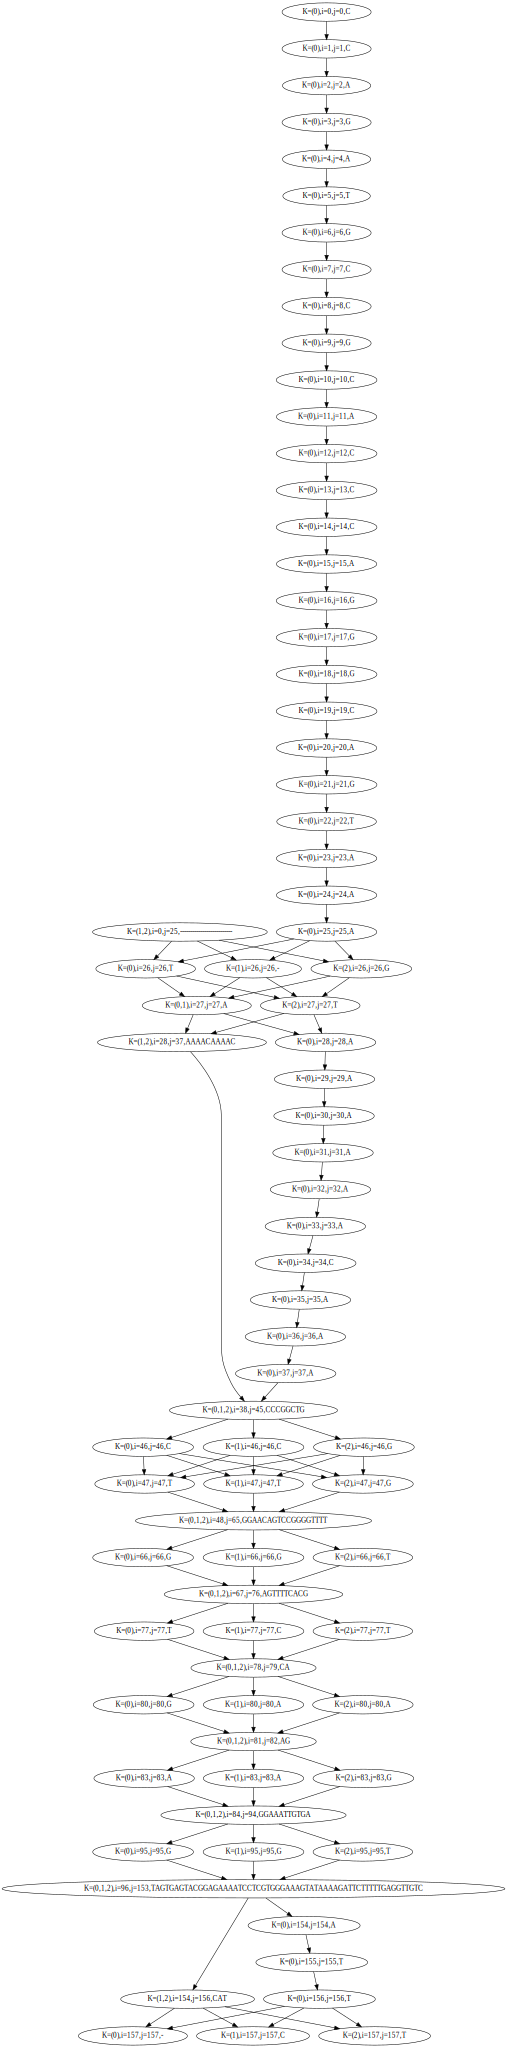

In [19]:
dg.digraph

In [20]:
list_nodes

[Node(K=(1, 2), i=0, j=25, label='--------------------------'),
 Node(K=(0,), i=26, j=26, label='T'),
 Node(K=(1, 2), i=0, j=25, label='--------------------------'),
 Node(K=(1,), i=26, j=26, label='-'),
 Node(K=(1, 2), i=0, j=25, label='--------------------------'),
 Node(K=(2,), i=26, j=26, label='G'),
 Node(K=(0,), i=0, j=0, label='C'),
 Node(K=(0,), i=1, j=1, label='C'),
 Node(K=(0,), i=1, j=1, label='C'),
 Node(K=(0,), i=2, j=2, label='A'),
 Node(K=(0,), i=2, j=2, label='A'),
 Node(K=(0,), i=3, j=3, label='G'),
 Node(K=(0,), i=3, j=3, label='G'),
 Node(K=(0,), i=4, j=4, label='A'),
 Node(K=(0,), i=4, j=4, label='A'),
 Node(K=(0,), i=5, j=5, label='T'),
 Node(K=(0,), i=5, j=5, label='T'),
 Node(K=(0,), i=6, j=6, label='G'),
 Node(K=(0,), i=6, j=6, label='G'),
 Node(K=(0,), i=7, j=7, label='C'),
 Node(K=(0,), i=7, j=7, label='C'),
 Node(K=(0,), i=8, j=8, label='C'),
 Node(K=(0,), i=8, j=8, label='C'),
 Node(K=(0,), i=9, j=9, label='G'),
 Node(K=(0,), i=9, j=9, label='G'),
 Node(K=(0

___

In [21]:
from collections import defaultdict

# graph in GAF format
lines_gfa = []

HEADER = f"H\t{NAME_MSA}"

# segments (nodes)
lines_segments = [] 
node2id={} # will be useful to add the lines/edges
for id_node, node in enumerate(_list_nodes):
    lines_segments.append(
        f"S\t{id_node}\t{node[-1]}"
    )

    node2id[node]=id_node

# links (edges)
lines_links=[]
data_paths = defaultdict(list)
for edge in _list_edges:
    node1, node2, seqs = edge[0], edge[1], edge[2]
    lines_links.append(
        f"L\t{node2id[node1]}\t+\t{node2id[node2]}\t+\t0M"
    )

    # paths
    for seq in seqs:
        data_paths[seq].extend([node1,node2])

lines_paths=[]
paths = dict()
for seq, nodes_seq in data_paths.items():
    nodes_seq = list(set(nodes_seq))
    id_nodes = [node2id[node] for node in sorted(nodes_seq, key=lambda node: node[1])]
    paths[seq] = ",".join([str(id_node)+"+" for id_node in id_nodes])
    lines_paths.append(
        f"P\tseq{seq}\t\t{paths[seq]}"
    )
lines_gfa.append(HEADER)
lines_gfa.extend(list(set(lines_segments)))
lines_gfa.extend(list(set(lines_links)))
lines_gfa.extend(lines_paths)

path_gfa = Path(f"../experiment/gfa/{NAME_MSA}.gfa")
path_gfa.parent.mkdir(exist_ok=True, parents=True)
with open(path_gfa,"w") as fp:
    for line in lines_gfa:
        fp.write(line + "\n")



In [22]:
# bandage labels
bandage_labels(path_gfa, path_save_labels=f"../experiment/gfa/{NAME_MSA}_bandage_labels.csv")


In [23]:
_list_edges

[(((0, 1, 2), 38, 45, 'CCCGGCTG'), ((2,), 46, 46, 'G'), (2,)),
 (((0,), 33, 33, 'A'), ((0,), 34, 34, 'C'), (0,)),
 (((0,), 156, 156, 'T'), ((0,), 157, 157, '-'), (0,)),
 (((0,), 28, 28, 'A'), ((0,), 29, 29, 'A'), (0,)),
 (((0,), 12, 12, 'C'), ((0,), 13, 13, 'C'), (0,)),
 (((1, 2), 0, 25, '--------------------------'), ((1,), 26, 26, '-'), (1,)),
 (((0,), 20, 20, 'A'), ((0,), 21, 21, 'G'), (0,)),
 (((2,), 80, 80, 'A'), ((0, 1, 2), 81, 82, 'AG'), (2,)),
 (((0, 1, 2), 78, 79, 'CA'), ((0,), 80, 80, 'G'), (0,)),
 (((0,), 95, 95, 'G'),
  ((0, 1, 2),
   96,
   153,
   'TAGTGAGTACGGAGAAAATCCTCGTGGGAAAGTATAAAAGATTCTTTTTGAGGTTGTC'),
  (0,)),
 (((0,), 156, 156, 'T'), ((1,), 157, 157, 'C'), ()),
 (((0,), 23, 23, 'A'), ((0,), 24, 24, 'A'), (0,)),
 (((1,), 46, 46, 'C'), ((0,), 47, 47, 'T'), ()),
 (((0,), 10, 10, 'C'), ((0,), 11, 11, 'A'), (0,)),
 (((0,), 156, 156, 'T'), ((2,), 157, 157, 'T'), ()),
 (((0,), 21, 21, 'G'), ((0,), 22, 22, 'T'), (0,)),
 (((0, 1, 2), 67, 76, 'AGTTTTCACG'), ((1,), 77, 77, 

In [24]:
_list_nodes

{((0,), 0, 0, 'C'),
 ((0,), 1, 1, 'C'),
 ((0,), 2, 2, 'A'),
 ((0,), 3, 3, 'G'),
 ((0,), 4, 4, 'A'),
 ((0,), 5, 5, 'T'),
 ((0,), 6, 6, 'G'),
 ((0,), 7, 7, 'C'),
 ((0,), 8, 8, 'C'),
 ((0,), 9, 9, 'G'),
 ((0,), 10, 10, 'C'),
 ((0,), 11, 11, 'A'),
 ((0,), 12, 12, 'C'),
 ((0,), 13, 13, 'C'),
 ((0,), 14, 14, 'C'),
 ((0,), 15, 15, 'A'),
 ((0,), 16, 16, 'G'),
 ((0,), 17, 17, 'G'),
 ((0,), 18, 18, 'G'),
 ((0,), 19, 19, 'C'),
 ((0,), 20, 20, 'A'),
 ((0,), 21, 21, 'G'),
 ((0,), 22, 22, 'T'),
 ((0,), 23, 23, 'A'),
 ((0,), 24, 24, 'A'),
 ((0,), 25, 25, 'A'),
 ((0,), 26, 26, 'T'),
 ((0,), 28, 28, 'A'),
 ((0,), 29, 29, 'A'),
 ((0,), 30, 30, 'A'),
 ((0,), 31, 31, 'A'),
 ((0,), 32, 32, 'A'),
 ((0,), 33, 33, 'A'),
 ((0,), 34, 34, 'C'),
 ((0,), 35, 35, 'A'),
 ((0,), 36, 36, 'A'),
 ((0,), 37, 37, 'A'),
 ((0,), 46, 46, 'C'),
 ((0,), 47, 47, 'T'),
 ((0,), 66, 66, 'G'),
 ((0,), 77, 77, 'T'),
 ((0,), 80, 80, 'G'),
 ((0,), 83, 83, 'A'),
 ((0,), 95, 95, 'G'),
 ((0,), 154, 154, 'A'),
 ((0,), 155, 155, 'T'),
 ((0

In [25]:
# constraint = model.getConstrByName("constraint2(1,28)")
# print(f"{model.getRow(constraint)} {constraint.Sense} {constraint.RHS}")